In [31]:
# import relevant depedencies
using LinearAlgebra
using TensorKit
using MPSKit
using Plots
using LaTeXStrings
using Statistics
using Colors
using ProgressMeter
using Plots.PlotMeasures
using Printf
include("julia_functions.jl")



generate_entangled_mps (generic function with 1 method)

For the compression of matrix product states, the dependency of the computational cost on certain variables should be well understood

First of all measure the influence L on the computation time to optimize the MPS using:\
\
R^10 => R^5    \
sigma = R^2 \
DMRG1


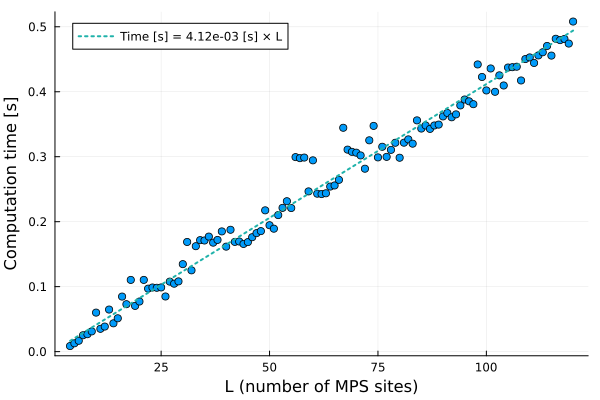

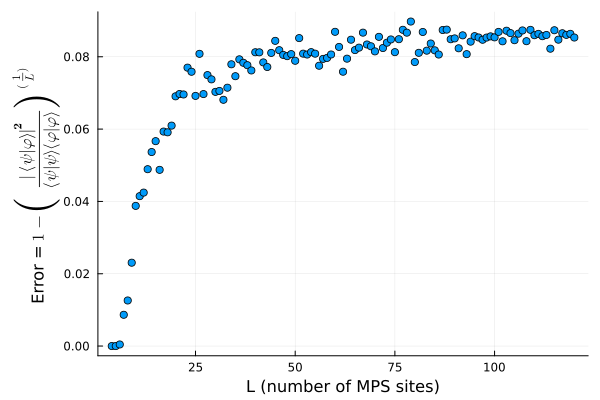

In [52]:
# initialize random tensor maps with the correct sizes for the approximated MPS 
# case1 - truncate a uniform MPS of chi = 20 to one of chi = 5




# Create a DMRG algorithm instance
alg = DMRG(;  # Choose DMRG (1-site) for this example
    maxiter = 40,  # Maximum number of iterations
    verbose = false,   # Verbosity level (0: silent, 1: basic, 2: detailed)
    tol = 1e-24
)


physical_index = ℝ^2
max_virtualspace_exact = 10
max_virtualspace_approx = ℝ^5


time_taken_function_of_L = []
fidelity_in_function_of_L = []
L_list = collect(4:120)

@showprogress for L in L_list

    Ψ_exact, S_max = generate_entangled_mps(L, max_virtualspace_exact, 2)

    Ψ_approx = FiniteMPS(                                                       # Generate a random state used for approximation 
        rand,                                                                   # with a smaller bond dimension
        Float64, 
        L, physical_index, 
        max_virtualspace_approx)

    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(Ψ_exact)), physicalspace(Ψ_exact, i))) for i in 1:length(Ψ_exact)]) # corresponding identity operator as an MPO

    time_taken = @elapsed begin                                                 # time how long it takes to compute the approximation
        Ψ_new, = approximate(Ψ_approx, (I_MPO, Ψ_exact), alg)
    end

    push!(time_taken_function_of_L, time_taken)
    error = 1-(dot(Ψ_new, Ψ_exact)^2/(dot(Ψ_new, Ψ_new)*dot(Ψ_exact, Ψ_exact)))^(1/L)
    push!(fidelity_in_function_of_L, error)

end

# make a linear fit using LinearAlgebra - package
β = L_list \ time_taken_function_of_L
β_str = @sprintf("%.2e", β)

# Plot the results in function of L
p = Plots.scatter(L_list, time_taken_function_of_L, 
              xlabel="L (number of MPS sites)", 
              ylabel="Computation time [s]", 
              label="",
              legend=false)
Plots.plot!(L_list, β * L_list, legend=true, label="Time [s] = $β_str [s] × L", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)
display(p)

display(Plots.scatter(L_list, fidelity_in_function_of_L, 
              xlabel="L (number of MPS sites)", 
              ylabel="Error = " * L"1 - \left( \textbf{{\frac{|\langle \psi | \varphi \rangle|^2}{\langle \psi | \psi \rangle \langle \varphi | \varphi \rangle}}}\right)^{(\frac{1}{L})}", 
              legend=false, left_margin = 5mm))


First of all measure the influence $\chi_{i}$ on the computation time to optimize the MPS using:\
\
R^range(5-50) => R^5    \
sigma = R^2 \
DMRG1


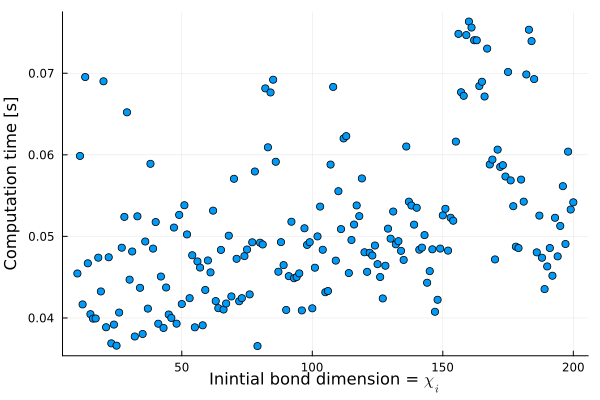

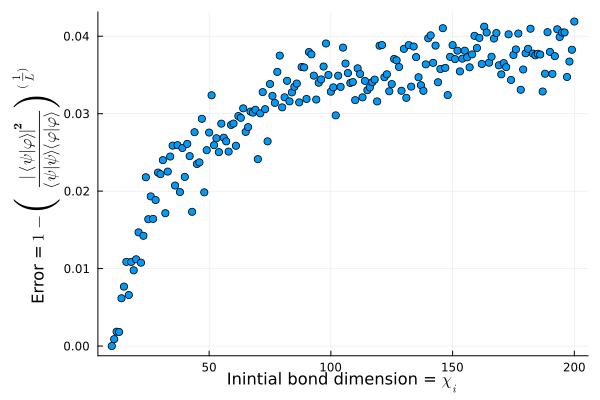

In [56]:
# initialize random tensor maps with the correct sizes for the approximated MPS 
# case1 - truncate a uniform MPS of chi = 20 to one of chi = 5




# Create a DMRG algorithm instance
alg = DMRG(;  # Choose DMRG (1-site) for this example
    maxiter = 40,  # Maximum number of iterations
    verbose = false,   # Verbosity level (0: silent, 1: basic, 2: detailed)
    tol = 1e-24
)


physical_index = ℝ^2
max_virtualspace_exact = collect(10:200)
max_virtualspace_approx = ℝ^10
L = 10

time_taken_function_of_chi_i = []
fidelity_in_function_of_chi_i = []


@showprogress for max_chi in max_virtualspace_exact

    Ψ_exact, S_max = generate_entangled_mps(L, max_chi, 2)

    Ψ_approx = FiniteMPS(                                                       # Generate a random state used for approximation 
        rand,                                                                   # with a smaller bond dimension
        Float64, 
        L, physical_index, 
        max_virtualspace_approx)

    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(Ψ_exact)), physicalspace(Ψ_exact, i))) for i in 1:length(Ψ_exact)]) # corresponding identity operator as an MPO

    time_taken = @elapsed begin                                                 # time how long it takes to compute the approximation
        Ψ_new, = approximate(Ψ_approx, (I_MPO, Ψ_exact), alg)
    end

    push!(time_taken_function_of_chi_i, time_taken)
    error = 1-(dot(Ψ_new, Ψ_exact)^2/(dot(Ψ_new, Ψ_new)*dot(Ψ_exact, Ψ_exact)))^(1/L)
    push!(fidelity_in_function_of_chi_i, error)

end

#TODO: MAYBE average the computational time [s] over 10 runs? 

# Plot the results in function of L
p = Plots.scatter(max_virtualspace_exact, time_taken_function_of_chi_i, 
              xlabel="Inintial bond dimension = " * L"\chi_i" , 
              ylabel="Computation time [s]", 
              label="",
              legend=false)
#Plots.plot!(max_virtualspace_exact, β * max_virtualspace_exact, legend=true, label="Time [s] = $β_str [s] × " * L"\chi", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)
display(p)

display(Plots.scatter(max_virtualspace_exact, fidelity_in_function_of_chi_i, 
              xlabel="Inintial bond dimension = " * L"\chi_i", 
              ylabel="Error = " * L"1 - \left( \textbf{{\frac{|\langle \psi | \varphi \rangle|^2}{\langle \psi | \psi \rangle \langle \varphi | \varphi \rangle}}}\right)^{(\frac{1}{L})}", 
              legend=false, left_margin = 5mm))


Measure the influence $\chi_{f}$ on the computation time to optimize the MPS using:\
\
R^range(50) => R^(5-50)    \
sigma = R^2 \
DMRG1


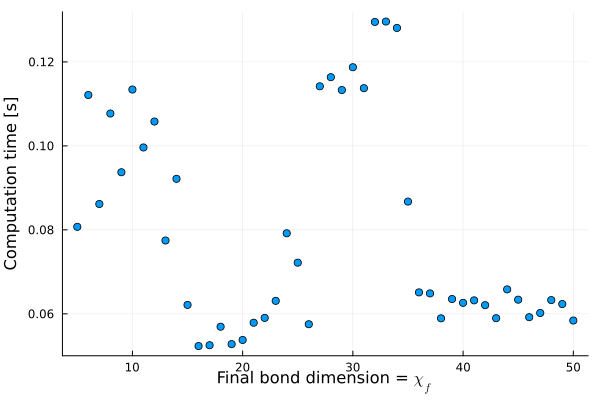

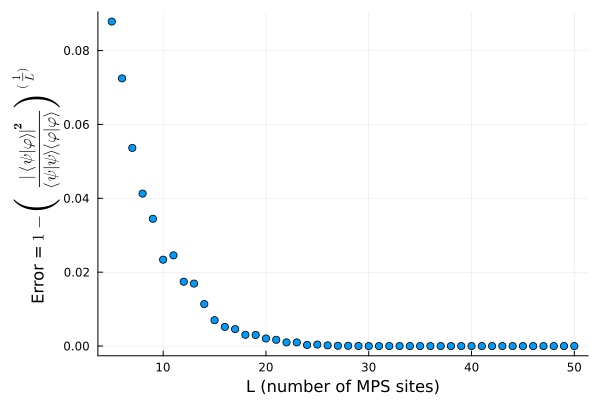

In [59]:
# initialize random tensor maps with the correct sizes for the approximated MPS 
# case1 - truncate a uniform MPS of chi = 20 to one of chi = 5
# Create a DMRG algorithm instance
alg = DMRG(;  # Choose DMRG (1-site) for this example
    maxiter = 40,  # Maximum number of iterations
    verbose = false,   # Verbosity level (0: silent, 1: basic, 2: detailed)
    tol = 1e-24
)


physical_index = ℝ^2
max_virtualspace_exact = 100
max_virtualspace_approx = ℝ^10
chi_approx_list = collect(5:100)
L = 10

time_taken_function_of_chi_f = []
fidelity_in_function_of_chi_f = []


@showprogress for max_chi in chi_approx_list

    Ψ_exact, S_max = generate_entangled_mps(L, max_virtualspace_exact, 2)

    Ψ_approx = FiniteMPS(                                                       # Generate a random state used for approximation 
        rand,                                                                   # with a smaller bond dimension
        Float64, 
        L, physical_index, 
        ℝ^max_chi)

    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(Ψ_exact)), physicalspace(Ψ_exact, i))) for i in 1:length(Ψ_exact)]) # corresponding identity operator as an MPO

    time_taken = @elapsed begin                                                 # time how long it takes to compute the approximation
        Ψ_new, = approximate(Ψ_approx, (I_MPO, Ψ_exact), alg)
    end

    push!(time_taken_function_of_chi_f, time_taken)
    error = 1-(dot(Ψ_new, Ψ_exact)^2/(dot(Ψ_new, Ψ_new)*dot(Ψ_exact, Ψ_exact)))^(1/L)
    push!(fidelity_in_function_of_chi_f, error)

end

#TODO: MAYBE average the computational time [s] over 10 runs? 

# Plot the results in function of L
p = Plots.scatter(chi_approx_list, time_taken_function_of_chi_f, 
              xlabel="Final bond dimension = " * L"\chi_f" , 
              ylabel="Computation time [s]", 
              label="",
              legend=false)
#Plots.plot!(max_virtualspace_exact, β * max_virtualspace_exact, legend=true, label="Time [s] = $β_str [s] × " * L"\chi", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)
display(p)

display(Plots.scatter(chi_approx_list, fidelity_in_function_of_chi_f, 
              xlabel="L (number of MPS sites)", 
              ylabel="Error = " * L"1 - \left( \textbf{{\frac{|\langle \psi | \varphi \rangle|^2}{\langle \psi | \psi \rangle \langle \varphi | \varphi \rangle}}}\right)^{(\frac{1}{L})}", 
              legend=false, left_margin = 5mm))


Measure the influence of the number of the amount of sweeps 
on the computation time to optimize the MPS using:\
\
R^10 => R^5
sigma = R^2 
DMRG1


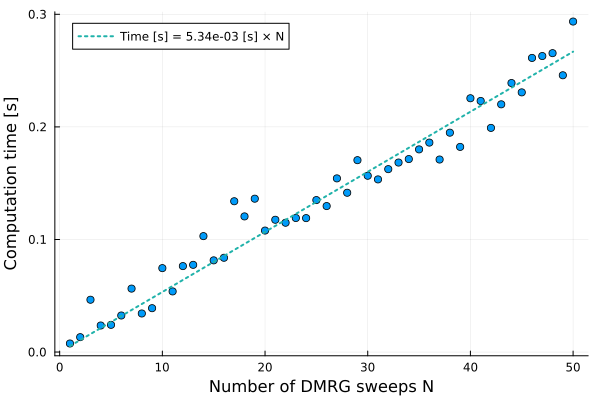

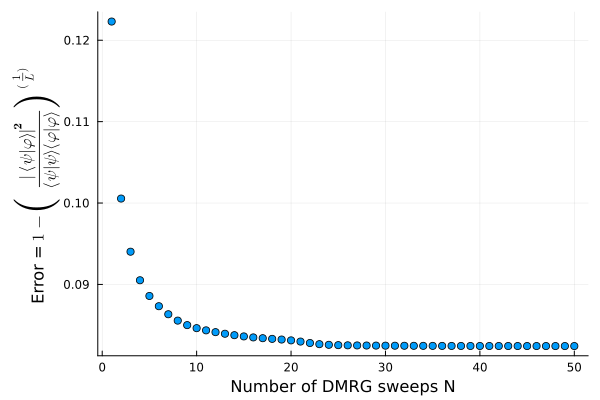

In [63]:
# initialize random tensor maps with the correct sizes for the approximated MPS 
# case1 - truncate a uniform MPS of chi = 20 to one of chi = 5




# Create a DMRG algorithm instance



physical_index = ℝ^2
max_virtualspace_exact = 10
max_virtualspace_approx = ℝ^5


time_taken_function_of_nr = []
fidelity_in_function_of_nr = []
max_iter_list = [j for j in 1:50]
L = 50

Ψ_exact, S_max = generate_entangled_mps(L, max_virtualspace_exact, 2)

Ψ_approx = FiniteMPS(                                                       # Generate a random state used for approximation 
        rand,                                                                   # with a smaller bond dimension
        Float64, 
        L, physical_index, 
        max_virtualspace_approx)


@showprogress for max_it in max_iter_list

    alg = DMRG(;  # Choose DMRG (1-site) for this example
        maxiter = max_it,  # Maximum number of iterations
        verbose = false,   # Verbosity level (0: silent, 1: basic, 2: detailed)
        tol = 1e-24
        )    

    

    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(Ψ_exact)), physicalspace(Ψ_exact, i))) for i in 1:length(Ψ_exact)]) # corresponding identity operator as an MPO

    time_taken = @elapsed begin                                                 # time how long it takes to compute the approximation
        Ψ_new, = approximate(Ψ_approx, (I_MPO, Ψ_exact), alg)
    end

    push!(time_taken_function_of_nr, time_taken)
    error = 1-(dot(Ψ_new, Ψ_exact)^2/(dot(Ψ_new, Ψ_new)*dot(Ψ_exact, Ψ_exact)))^(1/L)
    push!(fidelity_in_function_of_nr, error)

end

# make a linear fit using LinearAlgebra - package
β = max_iter_list \ time_taken_function_of_nr
β_str = @sprintf("%.2e", β)

# Plot the results in function of L
p = Plots.scatter(max_iter_list, time_taken_function_of_nr, 
              xlabel="Number of DMRG sweeps N", 
              ylabel="Computation time [s]", 
              label="",
              legend=false)
Plots.plot!(max_iter_list, β * max_iter_list, legend=true, label="Time [s] = $β_str [s] × N", linewidth=2, color=colorant"lightseagreen", linestyle=:dot)
display(p)

display(Plots.scatter(max_iter_list, fidelity_in_function_of_nr, 
              xlabel="Number of DMRG sweeps N", 
              ylabel="Error = " * L"1 - \left( \textbf{{\frac{|\langle \psi | \varphi \rangle|^2}{\langle \psi | \psi \rangle \langle \varphi | \varphi \rangle}}}\right)^{(\frac{1}{L})}", 
              legend=false, left_margin = 5mm))
